### Analysis of Model Results

This notebook analyzes the output of the GMRF model, loading posterior samples to visualize probabilities and model parameters.



In [1]:
import os
import glob
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import tqdm
import functools
from dataloader import load_data
from knn_utils import load_condition_knn

# --- Global Context and Caching ---

@functools.lru_cache(maxsize=None)
def get_global_condition_info():
    """Loads the full list of conditions and their KNN graph."""
    print("Loading global condition info (condition list and KNN)...")
    _, _, full_condition_list = load_data()
    condition_knn = load_condition_knn()
    condition_to_idx = {name: i for i, name in enumerate(full_condition_list)}
    print("Global condition info loaded.")
    return full_condition_list, condition_knn['indices'], condition_to_idx

_reconstituted_draws_cache = {}

# --- Main Loading and Interpolation Logic ---

def load_beta_samples_from_combined(base_dir: str = 'Res/'):
    """Loads beta parameter samples from the latest combined results directory."""
    cache_key = 'beta_samples'
    if cache_key in _reconstituted_draws_cache:
        return _reconstituted_draws_cache[cache_key]

    combined_dirs = sorted(glob.glob(os.path.join(base_dir, 'sharded_hierarchical_gp_*')))
    if not combined_dirs:
        raise FileNotFoundError("No 'sharded_hierarchical_gp_*' directories found.")
    
    latest_dir = combined_dirs[-1]
    print(f"Loading beta parameters from: {latest_dir}")
    payload = np.load(os.path.join(latest_dir, 'combined_post_samples.npy'), allow_pickle=True).item()
    
    if 'beta_cond' in payload:
        betas = jnp.asarray(payload['beta_cond'])
    elif 'tau' in payload and 'lambdas' in payload:
        tau = jnp.asarray(payload['tau']).reshape(-1, 1)
        lambdas = jnp.asarray(payload['lambdas'])
        betas = tau * lambdas
    else:
        raise KeyError("'beta_cond' or ('tau'/'lambdas') not found in combined results.")
        
    _reconstituted_draws_cache[cache_key] = betas
    return betas

def _interpolate_missing_lambdas_weighted(lambda_draws, beta_cond_draws, knn_indices):
    """Fills NaN values in Lambda draws using beta-weighted nearest-neighbor interpolation."""
    print("Performing beta-weighted nearest-neighbor interpolation...")
    
    lambda_draws_np = np.asarray(lambda_draws)
    beta_cond_draws_np = np.asarray(beta_cond_draws)
    
    missing_indices = np.argwhere(np.isnan(lambda_draws_np[0, :, :]))

    for pat_idx, cond_idx in tqdm(missing_indices, desc="Interpolating"):
        neighbor_g_indices = knn_indices[cond_idx, 1:]  # Exclude self
        
        # For each draw, compute the weighted average
        for draw_idx in range(lambda_draws_np.shape[0]):
            valid_neighbors = []
            neighbor_lambdas = []
            
            for neighbor_idx in neighbor_g_indices:
                if not np.isnan(lambda_draws_np[draw_idx, pat_idx, neighbor_idx]):
                    valid_neighbors.append(neighbor_idx)
                    neighbor_lambdas.append(lambda_draws_np[draw_idx, pat_idx, neighbor_idx])
            
            if not valid_neighbors:
                continue

            # Get beta values for the valid neighbors for the current draw
            neighbor_betas = beta_cond_draws_np[draw_idx, valid_neighbors]
            
            # Weighted average
            weighted_avg = np.sum(neighbor_betas * np.array(neighbor_lambdas))
            lambda_draws_np[draw_idx, pat_idx, cond_idx] = weighted_avg
            
    print("Interpolation complete.")
    return jnp.asarray(lambda_draws_np)

def load_reconstituted_lambda_draws(base_dir: str = 'Res/'):
    """
    Loads, pads, and interpolates Lambda draws using beta-weighted NN.
    Returns:
        lambda_draws: jnp.ndarray of shape (S, I, C)
        imputation_mask: np.ndarray of shape (I, C) where True indicates imputed entries
    """
    cache_key = 'lambda_draws_interpolated_weighted'
    if cache_key in _reconstituted_draws_cache:
        print("Returning cached reconstituted Lambda draws.")
        cached = _reconstituted_draws_cache[cache_key]
        # Backward compatibility if mask not cached
        if isinstance(cached, tuple) and len(cached) == 2:
            return cached
        else:
            return cached, np.isnan(np.asarray(cached[0]))  # best-effort mask

    print("Loading, padding, and interpolating Lambda draws from shards...")
    full_condition_list, knn_indices, condition_to_idx = get_global_condition_info()
    beta_cond_draws = load_beta_samples_from_combined(base_dir)
    C_full = len(full_condition_list)
    
    shard_dirs = sorted(glob.glob(os.path.join(base_dir, 'gmrf_*_shard_*')))
    shard_samples_info = [np.load(os.path.join(d, 'mcmc_samples.npy'), allow_pickle=True).item() for d in shard_dirs]
    min_draws = min(s['Lambda'].shape[0] for s in shard_samples_info)
    
    padded_shards = []
    for shard_samples in shard_samples_info:
        lambda_shard = shard_samples['Lambda'][:min_draws, :, :]
        _, I_shard, C_shard = lambda_shard.shape
        padded_lambda = np.full((min_draws, I_shard, C_full), np.nan)
        
        # This part remains a simplification, assuming first C_shard conditions
        padded_lambda[:, :, :C_shard] = lambda_shard
        padded_shards.append(padded_lambda)

    reconstituted_padded = np.concatenate(padded_shards, axis=1)

    # Build imputation mask BEFORE interpolation (same across draws)
    imputation_mask = np.isnan(reconstituted_padded[0])
    
    # Align beta draws with lambda draws
    beta_cond_aligned = beta_cond_draws[:min_draws, :C_full]
    
    reconstituted_final = _interpolate_missing_lambdas_weighted(reconstituted_padded, beta_cond_aligned, knn_indices)
    
    _reconstituted_draws_cache[cache_key] = (reconstituted_final, imputation_mask)
    print("Reconstitution and interpolation complete.")
    return reconstituted_final, imputation_mask




In [2]:
# Heatmap of posterior mean probabilities with imputation overlay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def _sigmoid(x: jnp.ndarray) -> jnp.ndarray:
    return 1.0 / (1.0 + jnp.exp(-x))

# Load the reconstituted Lambda draws and the imputation mask
lambda_draws, imputation_mask = load_reconstituted_lambda_draws()

# Compute posterior mean probabilities
P_mean = _sigmoid(jnp.mean(lambda_draws, axis=0))
print(f"Computed posterior mean probability matrix with shape: {P_mean.shape}")

# Compute row/column means and sort indices (descending)
row_means = np.asarray(P_mean).mean(axis=1)
col_means = np.asarray(P_mean).mean(axis=0)
row_sort_idx = np.argsort(-row_means)
col_sort_idx = np.argsort(-col_means)

# Apply sorting to P_mean and imputation mask for consistent overlays
P_mean_sorted = np.asarray(P_mean)[row_sort_idx][:, col_sort_idx]
imputation_mask_sorted = np.asarray(imputation_mask)[row_sort_idx][:, col_sort_idx]

print(
    f"Sorted P_mean by row/col means: rows {P_mean_sorted.shape[0]}, cols {P_mean_sorted.shape[1]}"
)




Loading, padding, and interpolating Lambda draws from shards...
Loading global condition info (condition list and KNN)...
Global condition info loaded.
Loading beta parameters from: Res/sharded_hierarchical_gp_20250903_144324
Performing beta-weighted nearest-neighbor interpolation...


Interpolating:   0%|          | 0/26439 [00:00<?, ?it/s]

Interpolation complete.
Reconstitution and interpolation complete.
Computed posterior mean probability matrix with shape: (6479, 43)
Sorted P_mean by row/col means: rows 6479, cols 43


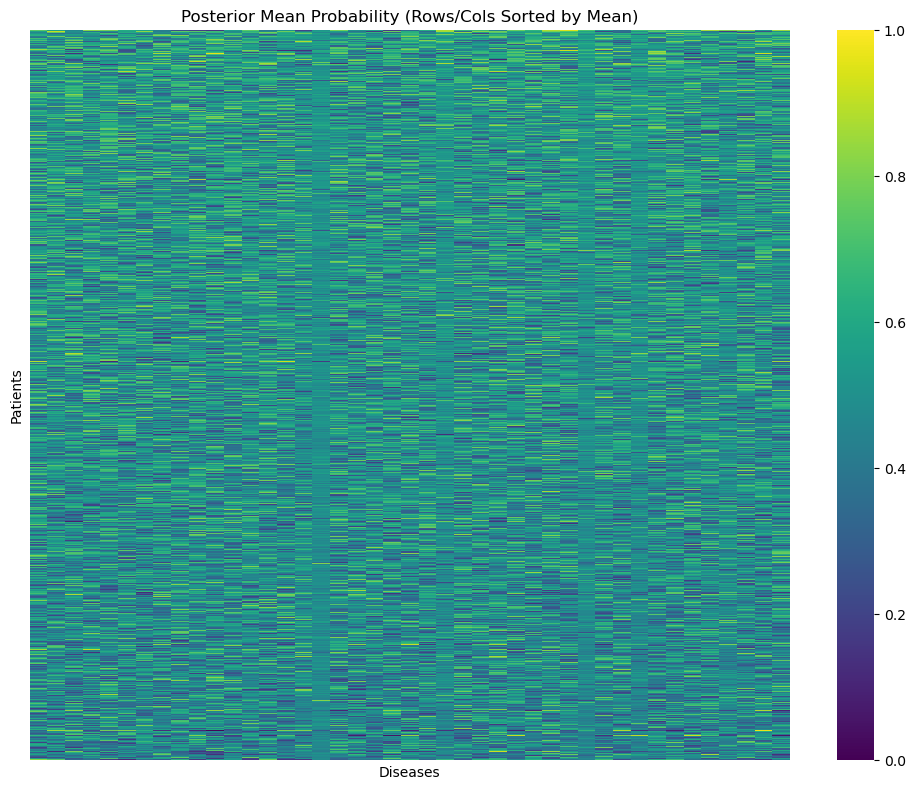

In [3]:
# Plot heatmap with rows/columns sorted by mean probability (descending)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(np.asarray(P_mean_sorted), cmap='viridis', vmin=0.0, vmax=1.0, cbar=True,
                 xticklabels=False, yticklabels=False)

# Optional: overlay imputed mask as semi-transparent gray, using sorted ordering
# overlay_sorted = np.ma.masked_where(~imputation_mask_sorted, imputation_mask_sorted)
# sns.heatmap(overlay_sorted, cmap=sns.color_palette(["#000000"], as_cmap=True), alpha=0.25,
#             cbar=False, xticklabels=False, yticklabels=False)

plt.title('Posterior Mean Probability (Rows/Cols Sorted by Mean)')
plt.xlabel('Diseases')
plt.ylabel('Patients')
plt.tight_layout()

# Save plot as PDF
plt.savefig('plots/posterior_mean_probability_heatmap_sorted.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

Loaded probability draws: (4000, 6479, 43); std matrix shape: (6479, 43)


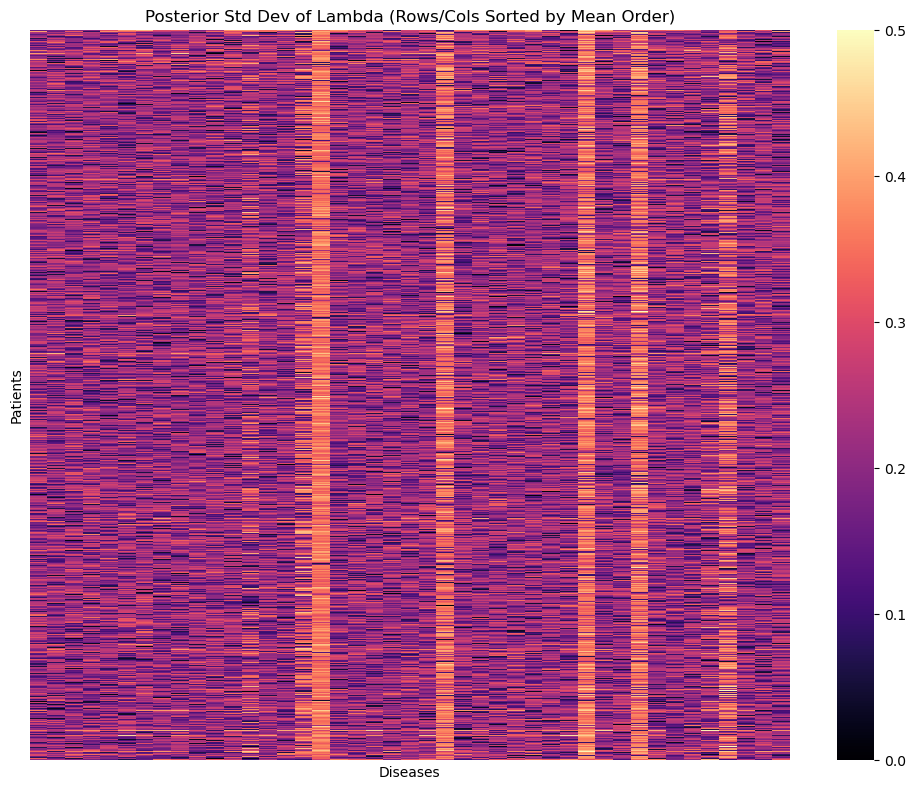

In [4]:
# Heatmap of posterior standard deviation (rows/cols sorted by mean order)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the reconstituted Lambda draws and mask from previous cell
if 'lambda_draws' not in locals() or 'imputation_mask' not in locals():
    lambda_draws, imputation_mask = load_reconstituted_lambda_draws()

# Ensure sort indices are available
if 'row_sort_idx' not in locals() or 'col_sort_idx' not in locals():
    # Recompute from P_mean if needed
    P_mean = _sigmoid(jnp.mean(lambda_draws, axis=0))
    row_means = np.asarray(P_mean).mean(axis=1)
    col_means = np.asarray(P_mean).mean(axis=0)
    row_sort_idx = np.argsort(-row_means)
    col_sort_idx = np.argsort(-col_means)

# Compute probabilities for each draw, then find the standard deviation
p_draws = _sigmoid(lambda_draws)
P_std = jnp.std(p_draws, axis=0)

# Add 0.3 to std at imputed cells to reflect higher uncertainty
P_std = P_std + 0.3 * jnp.asarray(imputation_mask, dtype=P_std.dtype)

print(f"Loaded probability draws: {p_draws.shape}; std matrix shape: {P_std.shape}")

# Apply the same row/column ordering used for P_mean
P_std_sorted = np.asarray(P_std)[row_sort_idx][:, col_sort_idx]

# Plot heatmap of posterior std with sorted axes
plt.figure(figsize=(10, 8))
ax = sns.heatmap(np.asarray(P_std_sorted), cmap='magma', vmin=0.0, vmax=0.5, cbar=True,
                 xticklabels=False, yticklabels=False)
# Optional overlay using sorted mask
# overlay_sorted = np.where(np.asarray(imputation_mask)[row_sort_idx][:, col_sort_idx], 1.0, np.nan)
# sns.heatmap(overlay_sorted, cmap=sns.color_palette(["#000000"], as_cmap=True), alpha=0.25,
#             cbar=False, xticklabels=False, yticklabels=False)
plt.title('Posterior Std Dev of Lambda (Rows/Cols Sorted by Mean Order)')
plt.xlabel('Diseases')
plt.ylabel('Patients')
plt.tight_layout()

# Save plot as PDF
plt.savefig('plots/posterior_std_probability_heatmap_sorted.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [6]:
# Confusion Matrix and Classification Report (excluding imputed cells)
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from dataloader import load_data

# Load ground truth from dataloader and align with predicted probabilities

def load_ground_truth_from_dataloader() -> np.ndarray:
    """
    Load A from dataloader, convert to 2D patient-by-condition binary matrix in {0,1}.
    """
    A, _, _ = load_data()
    A_2d = A[:, :, 0] if A.ndim == 3 else A
    if np.min(A_2d) < 0:
        A_2d = (A_2d + 1) / 2
    return A_2d.astype(np.int32)

# Ensure we have P_mean and the imputation mask
if 'P_mean' not in locals() or 'imputation_mask' not in locals():
     raise NameError("'P_mean' and/or 'imputation_mask' not defined. Please run previous cells first.")

A_true_full = load_ground_truth_from_dataloader()
A_true = A_true_full[:P_mean.shape[0], :P_mean.shape[1]]

# Binarize predictions at 0.5 threshold
A_pred = (P_mean >= 0.5).astype(np.int32)

# Exclude imputed cells
valid_mask = ~imputation_mask

y_true = A_true[valid_mask].flatten()
y_pred = np.asarray(A_pred)[valid_mask].flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
confusion_matrix_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
confusion_matrix_df = confusion_matrix_df.to_latex(index=True, header=True, float_format="%.3f")
print(confusion_matrix_df)
print("Confusion Matrix (excluding imputed cells):")
print(cm)

# Optionally, print classification report for more detail
print("\nClassification Report (excluding imputed cells):")
print(classification_report(y_true, y_pred, digits=3))


\begin{tabular}{lrr}
\toprule
 & Pred 0 & Pred 1 \\
\midrule
True 0 & 118563 & 119505 \\
True 1 & 7052 & 7038 \\
\bottomrule
\end{tabular}

Confusion Matrix (excluding imputed cells):
[[118563 119505]
 [  7052   7038]]

Classification Report (excluding imputed cells):
              precision    recall  f1-score   support

           0      0.944     0.498     0.652    238068
           1      0.056     0.500     0.100     14090

    accuracy                          0.498    252158
   macro avg      0.500     0.499     0.376    252158
weighted avg      0.894     0.498     0.621    252158



Loading beta parameters from: Res/sharded_hierarchical_gp_20250903_144324


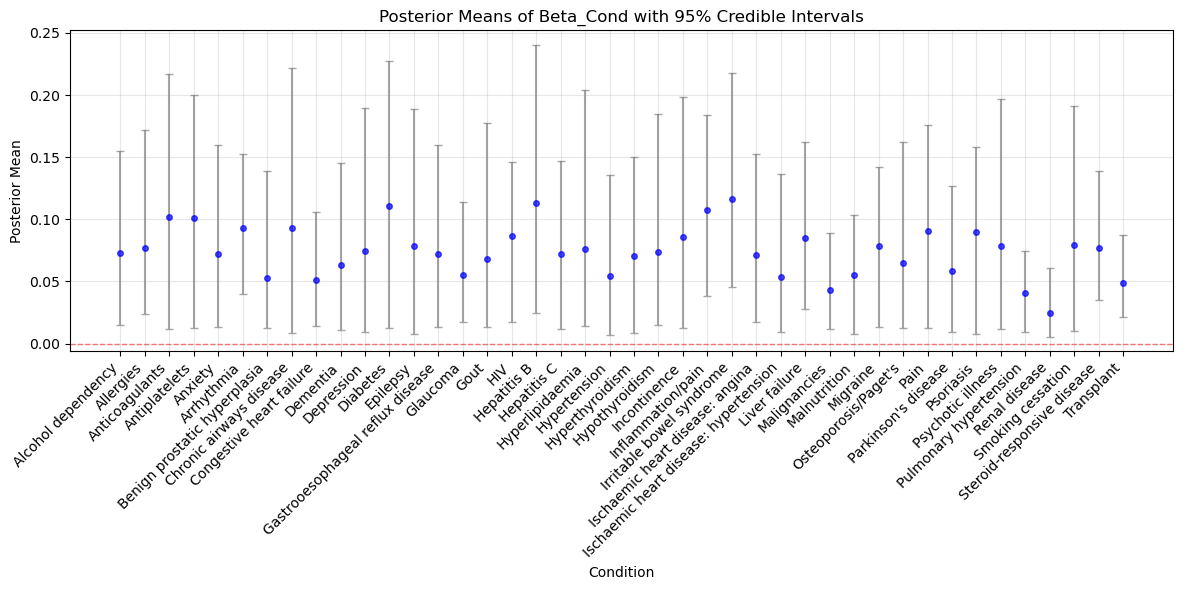


Summary of Beta_Cond Parameters:
Number of conditions: 42
Mean of all beta means: 0.0745
Number of betas with 95% CI excluding zero: 42


In [7]:
# Analysis of Beta Parameters from Combined Results
import os
import glob
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

def load_beta_samples_from_combined(base_dir: str = 'Res/'):
    """
    Loads beta parameter samples from the latest combined results directory.
    It reconstructs 'beta_cond' if it is not directly available.
    """
    combined_dirs = sorted(glob.glob(os.path.join(base_dir, 'sharded_hierarchical_gp_*')))
    if not combined_dirs:
        raise FileNotFoundError(f"No 'sharded_hierarchical_gp_*' directories found in '{base_dir}'.")
    
    latest_combined_dir = combined_dirs[-1]
    print(f"Loading beta parameters from: {latest_combined_dir}")
    
    payload = np.load(os.path.join(latest_combined_dir, 'combined_post_samples.npy'), allow_pickle=True).item()
    
    if 'beta_cond' in payload:
        beta_samples = jnp.asarray(payload['beta_cond'])
    elif 'tau' in payload and 'lambdas' in payload:
        tau = jnp.asarray(payload['tau']).reshape(-1, 1)
        lambdas = jnp.asarray(payload['lambdas'])
        beta_samples = tau * lambdas
    else:
        raise KeyError("'beta_cond' or ('tau' and 'lambdas') not found in combined results.")
        
    return beta_samples

# Load the beta samples
try:
    # Get condition names for plotting
    full_condition_list, _, _ = get_global_condition_info()
    condition_names = [c.name for c in full_condition_list]

    beta_samples = load_beta_samples_from_combined()
    
    num_betas = beta_samples.shape[1]

    # Match condition names to the number of betas
    if len(condition_names) > num_betas:
        print(f"Warning: Number of condition names ({len(condition_names)}) > number of betas ({num_betas}). Truncating names.")
        condition_names = condition_names[:num_betas]
    elif len(condition_names) < num_betas:
        print(f"Warning: Number of condition names ({len(condition_names)}) < number of betas ({num_betas}). Some betas will not be labeled.")
        condition_names.extend([f"Beta {i}" for i in range(len(condition_names), num_betas)])

    # Compute posterior mean and 95% credible interval
    beta_means = jnp.mean(beta_samples, axis=0)
    beta_lower, beta_upper = jnp.percentile(beta_samples, jnp.array([2.5, 97.5]), axis=0)

    # Compute error bars
    yerr = jnp.vstack([beta_means - beta_lower, beta_upper - beta_means])

    # Plot posterior means with error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(np.arange(num_betas), np.asarray(beta_means), yerr=np.asarray(yerr), 
                 capsize=3, capthick=1, fmt='o', markersize=4, 
                 color='blue', ecolor='gray', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    plt.xticks(np.arange(num_betas), condition_names, rotation=45, ha='right')
    plt.xlabel('Condition')
    plt.ylabel('Posterior Mean')
    plt.title('Posterior Means of Beta_Cond with 95% Credible Intervals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot as PDF
    plt.savefig('plots/beta_parameters_plot.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

    # Print summary statistics
    print(f"\nSummary of Beta_Cond Parameters:")
    print(f"Number of conditions: {num_betas}")
    print(f"Mean of all beta means: {jnp.mean(beta_means):.4f}")
    
    excludes_zero = jnp.sum((beta_lower > 0) | (beta_upper < 0))
    print(f"Number of betas with 95% CI excluding zero: {excludes_zero}")

except (FileNotFoundError, KeyError) as e:
    print(f"Skipping beta analysis: {e}")


In [8]:
import pandas as pd

# Prepare a DataFrame with condition names and beta means
beta_df = pd.DataFrame({
    'Condition': condition_names,
    'Beta Mean': np.asarray(beta_means),
    'Lower 95% CI': np.asarray(beta_lower),
    'Upper 95% CI': np.asarray(beta_upper)
})

# Sort by Beta Mean
beta_sorted = beta_df.sort_values('Beta Mean', ascending=False)

# Get top 3 and bottom 3
top3 = beta_sorted.head(3)
bottom3 = beta_sorted.tail(3)

# Concatenate for display
top_bottom = pd.concat([top3, bottom3])

# Reset index for display
top_bottom = top_bottom.reset_index(drop=True)

print("Top 3 and Bottom 3 Beta_Cond Parameters:")
display(top_bottom)
# Output the top_bottom DataFrame as LaTeX code
latex_code = top_bottom.to_latex(index=False, float_format="%.6f")
print("\nLaTeX code for Top 3 and Bottom 3 Beta_Cond Parameters table:\n")
print(latex_code)


Top 3 and Bottom 3 Beta_Cond Parameters:


,Condition,Beta Mean,Lower 95% CI,Upper 95% CI
0,Irritable bowel syndrome,0.116353,0.045656,0.217570
1,Hepatitis B,0.113504,0.024411,0.240393
2,Diabetes,0.110531,0.012355,0.227549
3,Malignancies,0.043412,0.011761,0.088875
4,Pulmonary hypertension,0.040538,0.009057,0.074139
5,Renal disease,0.024816,0.005612,0.060477



LaTeX code for Top 3 and Bottom 3 Beta_Cond Parameters table:

\begin{tabular}{lrrr}
\toprule
Condition & Beta Mean & Lower 95% CI & Upper 95% CI \\
\midrule
Irritable bowel syndrome & 0.116353 & 0.045656 & 0.217570 \\
Hepatitis B & 0.113504 & 0.024411 & 0.240393 \\
Diabetes & 0.110531 & 0.012355 & 0.227549 \\
Malignancies & 0.043412 & 0.011761 & 0.088875 \\
Pulmonary hypertension & 0.040538 & 0.009057 & 0.074139 \\
Renal disease & 0.024816 & 0.005612 & 0.060477 \\
\bottomrule
\end{tabular}



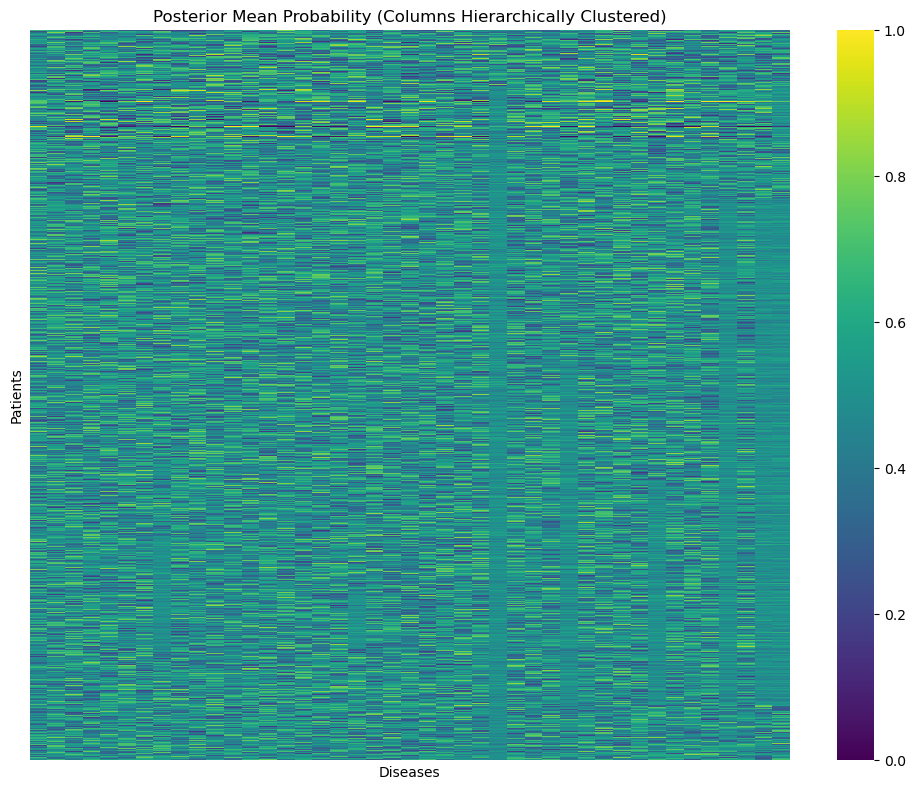

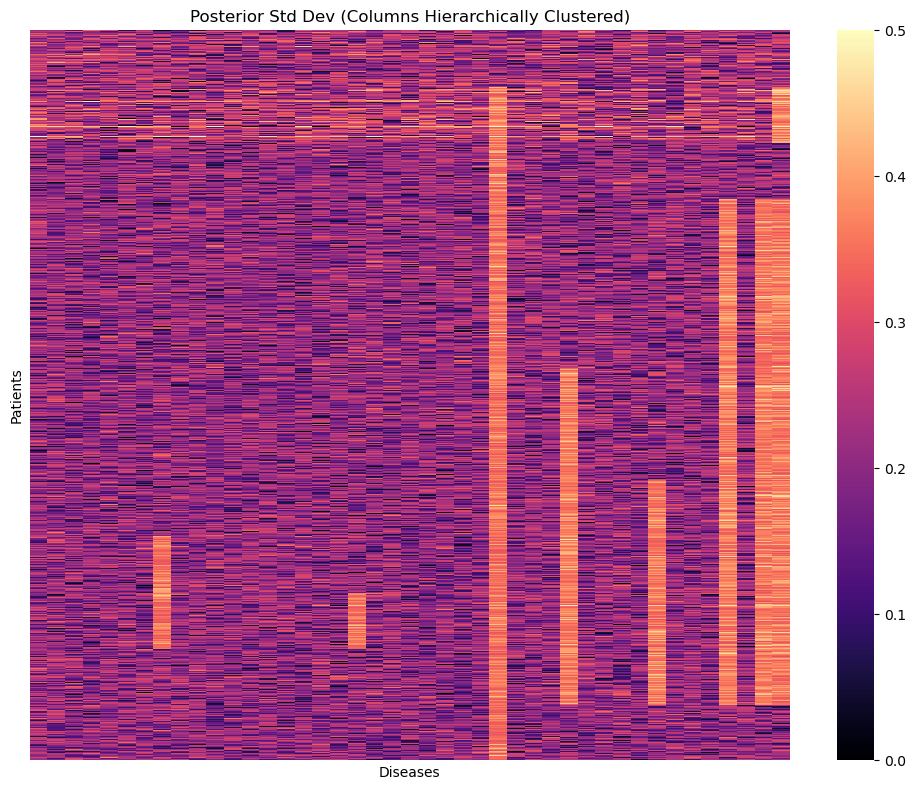

In [9]:
# Hierarchical clustering of columns (conditions) and reordered heatmaps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

# Ensure P_mean (and optionally P_std) are available
if 'P_mean' not in locals():
    lambda_draws, imputation_mask = load_reconstituted_lambda_draws()
    P_mean = _sigmoid(jnp.mean(lambda_draws, axis=0))

# Compute hierarchical clustering on columns using correlation distance
col_dist = pdist(np.asarray(P_mean).T, metric='correlation')
col_linkage = linkage(col_dist, method='average')
col_leaves = leaves_list(col_linkage)

# Reorder columns for the mean matrix
P_mean_colclustered = np.asarray(P_mean)[:, col_leaves]

plt.figure(figsize=(10, 8))
sns.heatmap(P_mean_colclustered, cmap='viridis', vmin=0.0, vmax=1.0, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Mean Probability (Columns Hierarchically Clustered)')
plt.xlabel('Diseases')
plt.ylabel('Patients')
plt.tight_layout()
plt.savefig('plots/posterior_mean_probability_heatmap_colclustered.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Prepare and plot the std matrix with the same column ordering
if 'P_std' not in locals():
    p_draws = _sigmoid(lambda_draws)
    P_std = jnp.std(p_draws, axis=0)
    P_std = P_std + 0.3 * jnp.asarray(imputation_mask, dtype=P_std.dtype)

P_std_colclustered = np.asarray(P_std)[:, col_leaves]

plt.figure(figsize=(10, 8))
sns.heatmap(P_std_colclustered, cmap='magma', vmin=0.0, vmax=0.5, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Std Dev (Columns Hierarchically Clustered)')
plt.xlabel('Diseases')
plt.ylabel('Patients')
plt.tight_layout()
plt.savefig('plots/posterior_std_probability_heatmap_colclustered.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()



/opt/miniconda3/envs/polypharm/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/miniconda3/envs/polypharm/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


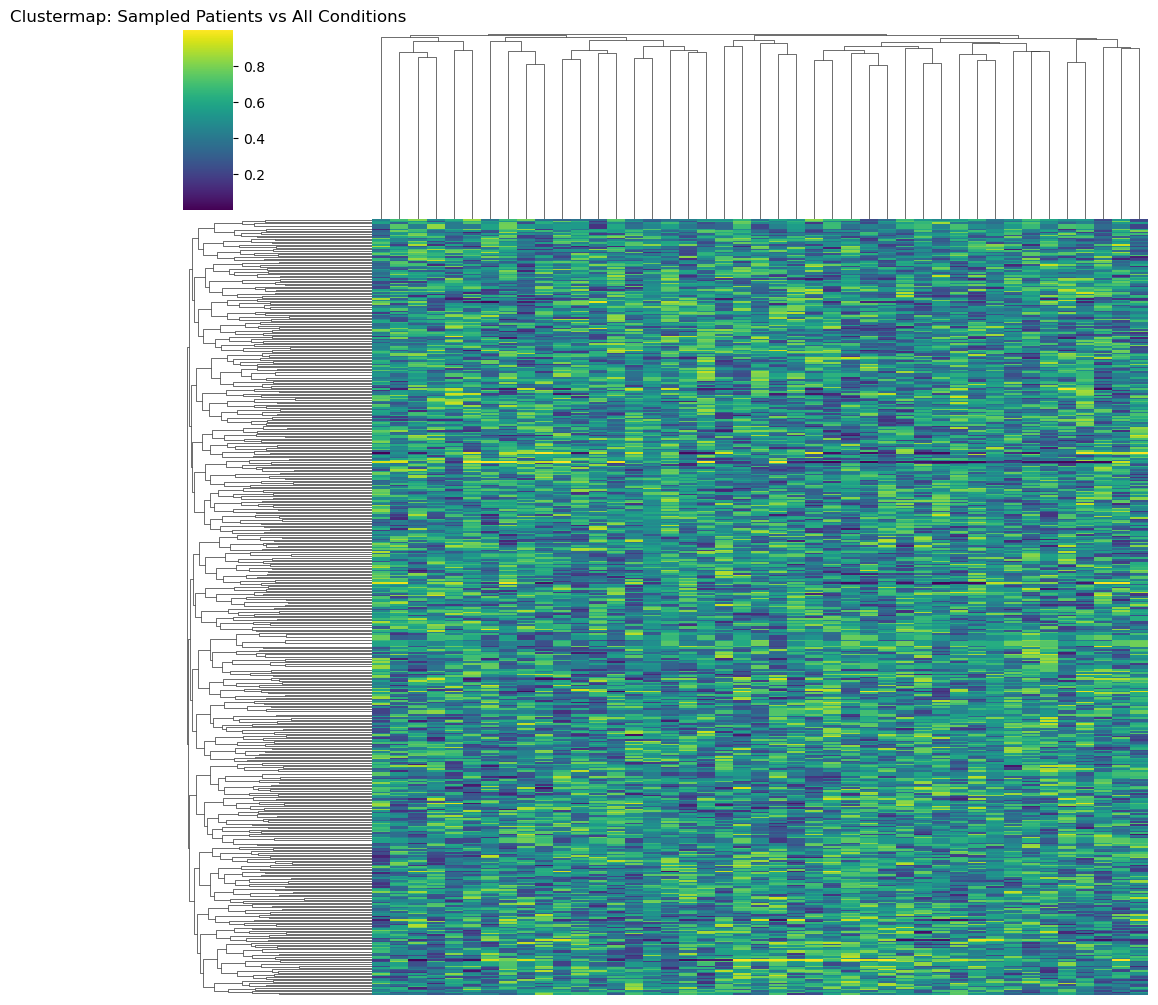

In [10]:
# Clustermap on a representative sample of patients and all conditions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

# Ensure P_mean is available
if 'P_mean' not in locals():
    lambda_draws, imputation_mask = load_reconstituted_lambda_draws()
    P_mean = _sigmoid(jnp.mean(lambda_draws, axis=0))

P_np = np.asarray(P_mean)
num_patients = P_np.shape[0]

# Choose a stratified sample favoring higher-variance rows to capture structure
row_vars = P_np.var(axis=1)
sample_size = min(500, num_patients)
sampled_rows = np.argsort(-row_vars)[:sample_size]

P_sample = P_np[sampled_rows, :]

# Build a clustermap with both row and column clustering (correlation metric)
cg = sns.clustermap(
    P_sample,
    method='average',
    metric='correlation',
    cmap='viridis',
    row_cluster=True,
    col_cluster=True,
    standard_scale=None,
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 10)
)
plt.title('Clustermap: Sampled Patients vs All Conditions')
plt.savefig('plots/posterior_mean_probability_clustermap_sample.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()



In [ ]:
# Posterior condition graphs for 3 random patients
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Ensure P_mean is available
if 'P_mean' not in locals():
    lambda_draws, imputation_mask = load_reconstituted_lambda_draws()
    P_mean = _sigmoid(jnp.mean(lambda_draws, axis=0))

# Optional: use condition names if available
try:
    full_condition_list, _, _ = get_global_condition_info()
    cond_names = [c.name for c in full_condition_list][:P_mean.shape[1]]
except Exception:
    cond_names = [f"Cond {j}" for j in range(P_mean.shape[1])]

P = np.asarray(P_mean)
I, C = P.shape

# Sample 3 random patients (fixed seed for reproducibility per run)
rng = np.random.default_rng(seed=42)
patient_indices = rng.choice(I, size=min(3, I), replace=False)
print(f"Selected patients: {patient_indices.tolist()}")

# Threshold for edge drawing to avoid clutter
edge_threshold = 0.10  # tune if needed

# Build and plot graphs
for idx, pat in enumerate(patient_indices, start=1):
    probs = P[pat]  # shape (C,)
    # Pairwise edge weights are product of probabilities
    # Build graph
    G = nx.Graph()
    for j in range(C):
        G.add_node(j, label=cond_names[j], p=float(probs[j]))
    # Add edges with weights
    for a in range(C):
        pa = probs[a]
        if pa <= 0:
            continue
        for b in range(a + 1, C):
            w = float(pa * probs[b])
            if w >= edge_threshold:
                G.add_edge(a, b, weight=w)

    # Layout - spring layout weighted by inverse of weight to pull strong edges closer
    if G.number_of_edges() > 0:
        inv_weights = {e: 1.0 / max(G.edges[e]['weight'], 1e-6) for e in G.edges}
        pos = nx.spring_layout(G, weight=None, k=None, seed=idx, iterations=200)
    else:
        pos = nx.spring_layout(G, seed=idx)

    # Node sizes proportional to probability
    node_sizes = [max(50.0, 800.0 * G.nodes[n]['p']) for n in G.nodes]
    node_colors = [G.nodes[n]['p'] for n in G.nodes]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='viridis')
    # Edge widths proportional to weight
    edge_widths = [2.0 + 6.0 * d['weight'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.6)
    # Labels for high-probability nodes
    labels = {n: G.nodes[n]['label'] for n in G.nodes if G.nodes[n]['p'] >= 0.25}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0.0, vmax=1.0))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Condition probability')

    plt.axis('off')
    plt.title(f'Posterior Condition Graph - Patient {int(pat)} (|V|={G.number_of_nodes()}, |E|={G.number_of_edges()})')
    plt.tight_layout()
    plt.savefig(f'plots/posterior_condition_graph_patient_{int(pat)}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

    # Export edges for inspection
    edges_df = pd.DataFrame([
        {
            'patient_index': int(pat),
            'cond_u_idx': int(u),
            'cond_v_idx': int(v),
            'cond_u': cond_names[u],
            'cond_v': cond_names[v],
            'edge_weight': float(d['weight'])
        }
        for u, v, d in G.edges(data=True)
    ])
    edges_df.to_csv(f'plots/posterior_condition_graph_patient_{int(pat)}.csv', index=False)

